## Importações

In [1]:
import os
import sox
import librosa

import random

import pygad

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
AUDIOS_DIRECTORY = "audios"
OUTPUT_DIRECTORY = "output/optimization"
INPUT_FILE = f"{AUDIOS_DIRECTORY}/original.wav"

## Implementação dos efeitos

In [3]:
class Effects:
    def __init__(self, input_file, output_file):
        """
        Inicializa a classe Effects.
        :param input_file: Arquivo de áudio de entrada.
        :param output_file: Arquivo de áudio de saída.
        """
        self.input_file = input_file
        self.output_file = output_file
        self.tfm = sox.Transformer()

    def _apply_effects(self):
        """Aplica os efeitos e gera o arquivo de saída."""
        if os.path.exists(self.output_file):
            os.remove(self.output_file)
        self.tfm.build(self.input_file, self.output_file)

    def _apply_reverb(self, reverberance=50, room_scale=50, pre_delay=20):
        """Aplica reverberação."""
        self.tfm.reverb(reverberance, room_scale=room_scale, pre_delay=pre_delay)

    def _apply_pitch(self, semitones=0):
        """Aplica alteração de pitch."""
        self.tfm.pitch(semitones)

    def _apply_flanger(self, delay=3, depth=1.5, regen=0, width=50, speed=0.4):
        """Aplica efeito de flanger."""
        self.tfm.flanger(delay, depth, regen, width, speed)

    def _apply_tremolo(self, speed=5, depth=40):
        """Aplica efeito de tremolo."""
        self.tfm.tremolo(speed, depth)

    def _apply_equalizer(self, frequency=2000, width_q=2, gain_db=6):
        """Aplica equalização."""
        self.tfm.equalizer(frequency, width_q, gain_db)

    def _apply_chorus(self, gain_in=0.5, gain_out=0.9, n_voices=3, delays=[20], decays=[0.5], speeds=[0.5], depths=[2]):
        """Aplica efeito de chorus."""
        self.tfm.chorus(gain_in, gain_out, n_voices, delays, decays, speeds, depths)

    def apply_effects(self, effects_params):
        """
        Aplica uma combinação de efeitos conforme os parâmetros passados.
        :param effects_params: Dicionário contendo os efeitos e seus parâmetros.
        """
        for effect, params in effects_params.items():
            if hasattr(self, f"_apply_{effect}"):
                getattr(self, f"_apply_{effect}")(**params)
        self._apply_effects()

    # Efeitos predefinidos
    def apply_revhall(self, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Reverberação de auditório."""
        self.apply_effects({"reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}})

    def apply_fallingamajor(self, semitones=0, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Som eletrônico (bmajor) com reverberação."""
        self.apply_effects({
            "pitch": {"semitones": semitones},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}
        })

    def apply_bmajor(self, semitones=0, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Som eletrônico (bmajor) com reverberação."""
        self.apply_effects({
            "pitch": {"semitones": semitones},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}
        })

    def apply_dmajor(self, semitones=0, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Som eletrônico (dmajor) com reverberação."""
        self.apply_effects({
            "pitch": {"semitones": semitones},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}
        })

    def apply_fmajor(self, semitones=0, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Som eletrônico (fmajor) com reverberação."""
        self.apply_effects({
            "pitch": {"semitones": semitones},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}
        })

    def apply_semitonescale(self, semitones=0, reverberance=50, room_scale=50, pre_delay=20):
        """Efeito: Escala de semitons eletrônica com reverberação."""
        self.apply_effects({
            "pitch": {"semitones": semitones},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay}
        })

    def apply_childvoice(self, pitch_shift=6, reverberance=30, room_scale=30, pre_delay=10):
        """Efeito: Voz de criança."""
        self.apply_effects({
            "pitch": {"semitones": pitch_shift},
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay},
            "equalizer": {"frequency": 2000, "width_q": 2, "gain_db": 6}
        })

    def apply_magicechomale(self, reverberance=90, room_scale=80, pre_delay=50, pitch_shift=-4, chorus=False):
        """Efeito: Eco mágico masculino."""
        effects = {
            "reverb": {"reverberance": reverberance, "room_scale": room_scale, "pre_delay": pre_delay},
            "pitch": {"semitones": pitch_shift}
        }
        if chorus:
            n_voices = 3  # Number of voices in the chorus effect
            effects["chorus"] = {
                "gain_in": 0.5,
                "gain_out": 0.9,
                "n_voices": n_voices,
                "delays": [20] * n_voices,  # Ensure delays has the same length as n_voices
                "decays": [0.5] * n_voices,  # Ensure decays has the same length as n_voices
                "speeds": [0.5] * n_voices,  # Ensure speeds has the same length as n_voices
                "depths": [2] * n_voices,    # Ensure depths has the same length as n_voices
            }
        
        self.apply_effects(effects)

## Otimização

### Effect 2 - Rev Hall 2

In [4]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    AUDIOS_DIRECTORY = "audios"
    OUTPUT_DIRECTORY = "output"

    # Arquivos de entrada e saída
    input_file = f"{AUDIOS_DIRECTORY}/original.wav"
    output_file = f"{OUTPUT_DIRECTORY}/optimization/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do reverb
    reverberance, room_scale, pre_delay = solution

    # Aplica o efeito de reverb com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_revhall(reverberance=reverberance, room_scale=room_scale, pre_delay=pre_delay)
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [5]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revhall2.wav"

GA_CONFIG = {
    "num_generations": 50,
    "num_parents_mating": 5,
    "sol_per_pop": 20,
    "num_genes": 3,
    "gene_space": [
        {"low": 0, "high": 100},  # reverberance
        {"low": 0, "high": 100},  # room_scale
        {"low": 0, "high": 100},  # pre_delay
    ],
    "mutation_type": "random",
    "mutation_percent_genes": 34,
}

In [6]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [7]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [76.11337168 16.91206078  1.31581308], Fitness: 258.7720031738281


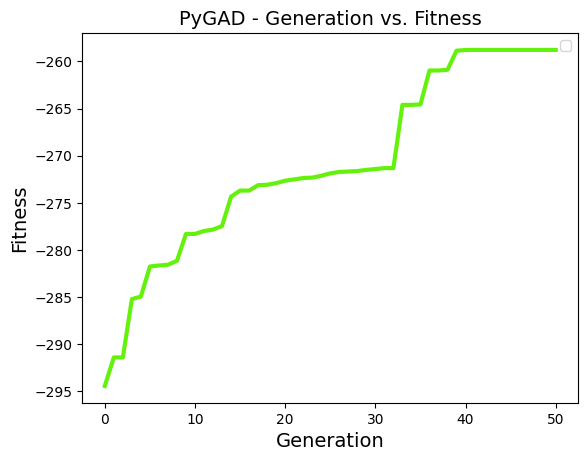

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 2')

In [8]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 2", fontsize=12, fontweight='bold')

In [9]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-revhall2.png')

In [10]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/revhall2.wav"

reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_revhall(reverberance=reverberance, room_scale=room_scale, pre_delay=pre_delay)

### Effect 5 - Falling A Major

In [12]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    # Arquivo de saída temporário
    output_file = f"{output_directory}/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do fallingamajor
    semitones, reverberance, room_scale, pre_delay = solution

    # Aplica o efeito fallingamajor com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_fallingamajor(
        semitones=semitones,
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [13]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revstagea.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (parâmetros a serem otimizados)
    "gene_space": [
        {"low": -12, "high": 12},   # semitones (pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 34,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [14]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [15]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [ 0.88873522 40.61038141  2.35117528  3.6044605 ], Fitness: 255.0537872314453


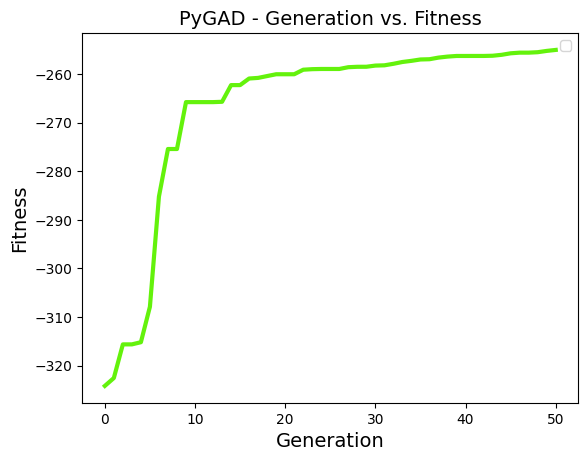

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 5')

In [16]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 5", fontsize=12, fontweight='bold')

In [17]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-fallingamajor.png')

In [18]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/fallingamajor.wav"

semitones, reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_fallingamajor(
    semitones=semitones,
    reverberance=reverberance,
    room_scale=room_scale,
    pre_delay=pre_delay
)

### Effect 8 - B Major

In [18]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    # Arquivo de saída temporário
    output_file = f"{output_directory}/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do bmajor
    semitones, reverberance, room_scale, pre_delay = solution
    
    # Aplica o efeito bmajor com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_bmajor(
        semitones=semitones,
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [19]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revstagebb.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (apenas semitones)
    "gene_space": [
        {"low": -12, "high": 12},   # semitones (pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 34,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [20]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [21]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [-0.9684845  46.47693393 30.10663426  3.71118787], Fitness: 309.7524719238281


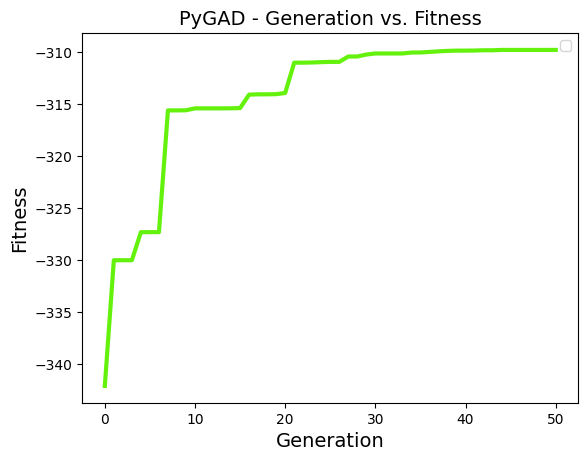

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 8')

In [22]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 8", fontsize=12, fontweight='bold')

In [23]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-bmajor.png')

In [24]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/bmajor.wav"

semitones, reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_bmajor(
    semitones=semitones,
    reverberance=reverberance,
    room_scale=room_scale,
    pre_delay=pre_delay
)

### Effect 11 - D Major

In [25]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    # Arquivo de saída temporário
    output_file = f"{output_directory}/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do dmajor
    semitones, reverberance, room_scale, pre_delay = solution
    
    # Aplica o efeito bmajor com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_dmajor(
        semitones=semitones,
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [26]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revstagedb.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (apenas semitones)
    "gene_space": [
        {"low": -12, "high": 12},   # semitones (pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 34,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [27]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [28]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [ 1.48975605 38.35602799 83.4222327  83.3018649 ], Fitness: 334.2950744628906


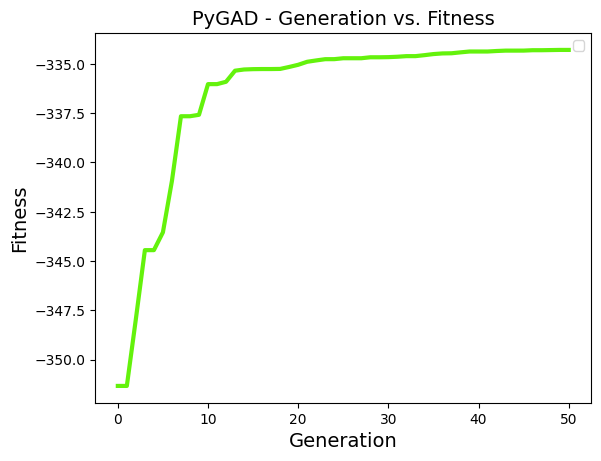

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 11')

In [29]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 11", fontsize=12, fontweight='bold')

In [30]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-dmajor.png')

In [31]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/dmajor.wav"

semitones, reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_dmajor(
    semitones=semitones,
    reverberance=reverberance,
    room_scale=room_scale,
    pre_delay=pre_delay
)

### Effect 14 - F Major

In [32]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    # Descompacta os parâmetros do fmajor
    semitones, reverberance, room_scale, pre_delay = solution
    
    # Aplica o efeito bmajor com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_fmajor(
        semitones=semitones,
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [33]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revstagefb.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (apenas semitones)
    "gene_space": [
        {"low": -12, "high": 12},   # semitones (pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 34,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [34]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [35]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [-1.20520643 49.72916571 56.60214168  6.19880841], Fitness: 298.1694030761719


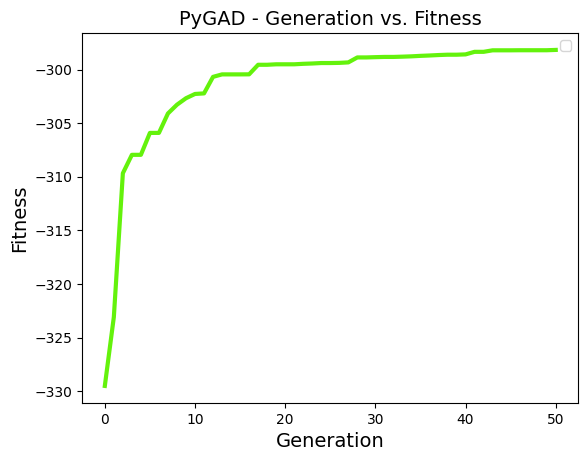

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 14')

In [36]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 14", fontsize=12, fontweight='bold')

In [37]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-fmajor.png')

In [38]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/fmajor.wav"

semitones, reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_fmajor(
    semitones=semitones,
    reverberance=reverberance,
    room_scale=room_scale,
    pre_delay=pre_delay
)

### Effect 17 - Semitone Scale

In [39]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    # Descompacta os parâmetros do dmajor
    semitones, reverberance, room_scale, pre_delay = solution
    
    # Aplica o efeito bmajor com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_semitonescale(
        semitones=semitones,
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [40]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/revstagegtht.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (apenas semitones)
    "gene_space": [
        {"low": -12, "high": 12},   # semitones (pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 34,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [41]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [42]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [ 0.68265126 38.36920664 41.51898487 31.85403576], Fitness: 300.8078308105469


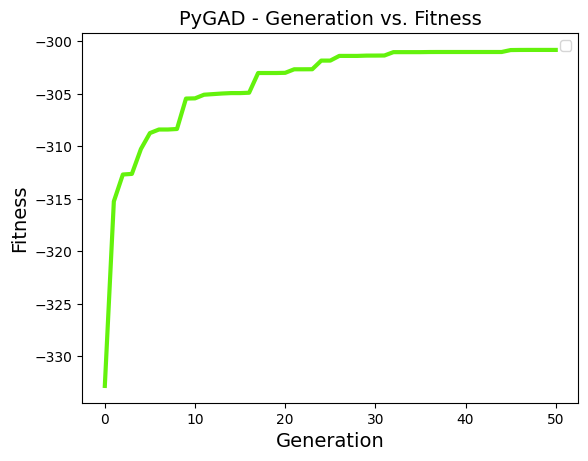

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 17')

In [43]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 17", fontsize=12, fontweight='bold')

In [44]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-semitonescale.png')

In [45]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/semitonescale.wav"

semitones = solution[0]

effects = Effects(input_file, output_file)
effects.apply_semitonescale(semitones=semitones)

### Effect 20 - Child Voice

In [46]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    AUDIOS_DIRECTORY = "audios"
    OUTPUT_DIRECTORY = "output"

    # Arquivos de entrada e saída
    input_file = f"{AUDIOS_DIRECTORY}/original.wav"
    output_file = f"{OUTPUT_DIRECTORY}/optimization/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do efeito de voz de criança
    pitch_shift, reverberance, room_scale, pre_delay = solution

    # Aplica o efeito de voz de criança com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_childvoice(pitch_shift=pitch_shift, reverberance=reverberance, room_scale=room_scale, pre_delay=pre_delay)
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [47]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/phaser.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 4,                 # Número de genes (parâmetros a serem otimizados)
    "gene_space": [
        {"low": -12, "high": 12},   # pitch_shift (semitons, pode variar de -12 a +12)
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 10,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [48]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [49]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [ 6.54406775 76.41307861 87.44620847  2.86027176], Fitness: 304.9408874511719


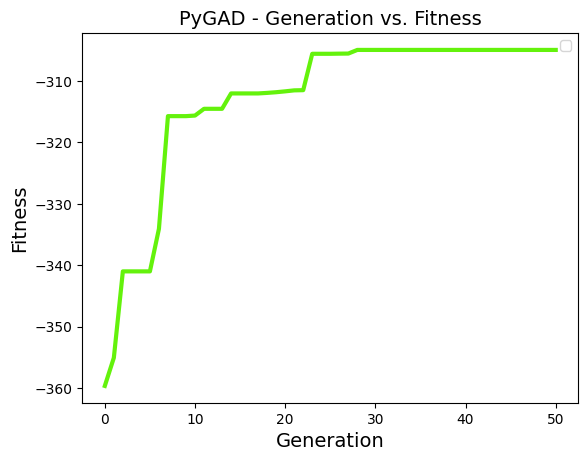

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 20')

In [50]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 20", fontsize=12, fontweight='bold')

In [51]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-childvoice.png')

In [52]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/childvoice.wav"

pitch_shift, reverberance, room_scale, pre_delay = solution

effects = Effects(input_file, output_file)
effects.apply_childvoice(
    pitch_shift=pitch_shift, 
    reverberance=reverberance, 
    room_scale=room_scale, 
    pre_delay=pre_delay
)

### Effect 23 - Magic Echo Male

In [53]:
def fitness_function(ga_instance, solution, solution_idx, input_file, reference_file, output_directory):
    
    AUDIOS_DIRECTORY = "audios"
    OUTPUT_DIRECTORY = "output"

    # Arquivos de entrada e saída
    input_file = f"{AUDIOS_DIRECTORY}/original.wav"
    output_file = f"{OUTPUT_DIRECTORY}/optimization/temp/temp_{solution_idx}.wav"
    
    # Descompacta os parâmetros do efeito de eco mágico masculino
    reverberance, room_scale, pre_delay, pitch_shift, chorus = solution

    # Aplica o efeito de eco mágico masculino com os parâmetros do AG
    effects = Effects(input_file, output_file)
    effects.apply_magicechomale(
        reverberance=reverberance,
        room_scale=room_scale,
        pre_delay=pre_delay,
        pitch_shift=pitch_shift,
        chorus=bool(chorus)
    )
    
    # Carrega os áudios processado e de referência
    processed, sr = librosa.load(output_file, sr=None)
    reference, sr = librosa.load(reference_file, sr=None)
    
    # Certifica-se de que os sinais tenham o mesmo tamanho
    min_len = min(len(processed), len(reference))
    processed = processed[:min_len]
    reference = reference[:min_len]
    
    # Converte para espectrogramas STFT
    D_processed = librosa.stft(processed)
    D_reference = librosa.stft(reference)
    
    # Obtém as magnitudes (descarta fase)
    mag_processed = np.abs(D_processed)
    mag_reference = np.abs(D_reference)
    
    # Normaliza para evitar influência da amplitude
    mag_processed /= np.max(mag_processed)
    mag_reference /= np.max(mag_reference)

    # Calcula a diferença espectral como fitness (quanto menor, melhor)
    fitness = -np.sum((mag_reference - mag_processed) ** 2)  # PyGAD maximiza, então invertemos o sinal
    
    return fitness

In [54]:
REFERENCE_FILE = f"{AUDIOS_DIRECTORY}/autowah.wav"

GA_CONFIG = {
    "num_generations": 50,          # Número de gerações
    "num_parents_mating": 5,        # Número de soluções que serão selecionadas como pais
    "sol_per_pop": 20,              # Número de soluções (indivíduos) na população
    "num_genes": 5,                 # Número de genes (parâmetros a serem otimizados)
    "gene_space": [
        {"low": 0, "high": 100},    # reverberance (de 0 a 100)
        {"low": 0, "high": 100},    # room_scale (de 0 a 100)
        {"low": 0, "high": 100},    # pre_delay (de 0 a 100)
        {"low": -6, "high": 6},   # pitch_shift (semitons, pode variar de -6 a +6)
        {"low": 0, "high": 1},      # chorus (0 = desligado, 1 = ligado)
    ],
    "mutation_type": "random",      # Tipo de mutação (aleatória)
    "mutation_percent_genes": 10,   # Porcentagem de genes que sofrerão mutação
    "parent_selection_type": "sss", # Método de seleção de pais (steady-state selection)
    "crossover_type": "single_point", # Tipo de crossover (ponto único)
    "keep_parents": 1,              # Número de pais que serão mantidos na próxima geração
}

In [55]:
ga_instance = pygad.GA(
    fitness_func=lambda ga_instance, solution, solution_idx: fitness_function(
        ga_instance, solution, solution_idx, INPUT_FILE, REFERENCE_FILE, OUTPUT_DIRECTORY
    ),
    **GA_CONFIG
)

In [56]:
ga_instance.run()

solution, solution_fitness, _ = ga_instance.best_solution()
print(f"Melhor solução: {solution}, Fitness: {-solution_fitness}")

Melhor solução: [20.10344428 57.56586432  6.11855617  1.7067244   0.74797803], Fitness: 295.6398010253906


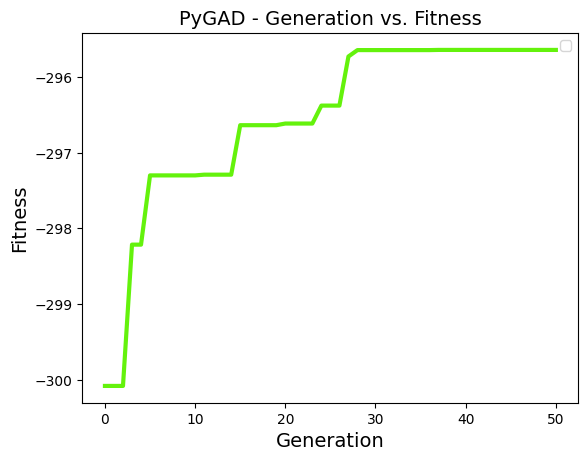

Text(0.5, 1.0, 'Fitness x Gerações - Efeito 23')

In [57]:
fig = ga_instance.plot_fitness()
ax = fig.axes[0]
ax.set_title("Fitness x Gerações - Efeito 23", fontsize=12, fontweight='bold')

In [58]:
fig.savefig(f'{OUTPUT_DIRECTORY}/graphics/fitness-magicechomale.png')

In [59]:
input_file = f"{AUDIOS_DIRECTORY}/original.wav"
output_file = f"{OUTPUT_DIRECTORY}/results/magicechomale.wav"

reverberance, room_scale, pre_delay, pitch_shift, chorus = solution

effects = Effects(input_file, output_file)
effects.apply_magicechomale(
    reverberance=reverberance,
    room_scale=room_scale,
    pre_delay=pre_delay,
    pitch_shift=pitch_shift,
    chorus=bool(chorus)
)